# Adição do Campo de Classe Processual no Modelo Truncated

Nesse notebook será avaliada a influência da classe processual do acórdão, representado pelo campo 'tipo_acordao', na eficácia do modelo FrontBack para classificação de acórdãos dentre os ramos do direito.

Para isso, será feito um treinamento de modelo com aproximação FrontBack juntando os textos das ementas junto com os textos das classes processuais. Por fim é feita uma pequena avaliação do modelo baseada em métricas básicas.

## Inicialização e definiçao de constantes

Como uma etapa inicial, toda a inicialização do notebook será concentrada no início desse documento. Os conteúdos contidos aqui são:

1. Instalação de bibliotecas externas
2. Importação de biblioteca
3. Definição de valores constantes que podem ter seu uso replicado ao longo do notebook
4. Inicialização do sistema de arquivos integrado ao Google Drive

In [1]:
# Installation of 3rd party libraries

!pip install transformers
!pip install --upgrade pytorch-lightning

     |████████████████████████████████| 3.1 MB 4.4 MB/s 
     |████████████████████████████████| 895 kB 38.2 MB/s 
     |████████████████████████████████| 59 kB 4.5 MB/s 
     |████████████████████████████████| 596 kB 60.0 MB/s 
     |████████████████████████████████| 3.3 MB 45.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 523 kB 4.3 MB/s 
     |████████████████████████████████| 829 kB 43.3 MB/s 
     |████████████████████████████████| 329 kB 65.3 MB/s 
     |████████████████████████████████| 132 kB 67.3 MB/s 
     |████████████████████████████████| 1.1 MB 43.7 MB/s 
     |████████████████████████████████| 271 kB 56.6 MB/s 
     |████████████████████████████████| 160 kB 54.9 MB/s 
     |████████████████████████████████| 192 kB 57.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=820696c6f48858

In [2]:
# Imports

from google.colab import drive
import pandas as pd
import numpy as np
from transformers import BertTokenizerFast as BertTokenizer, BertModel, BertForSequenceClassification, AdamW, get_cosine_schedule_with_warmup, Trainer, TrainingArguments
from enum import Enum
from typing import List
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, SequentialSampler
import re
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Constants

CONSTANTS = {
    'TRAINING_DATASET': '/content/drive/My Drive/MAC499 - Kaique e Yurick/DB/Train_Dataset.csv',
    'VALIDATION_DATASET': '/content/drive/My Drive/MAC499 - Kaique e Yurick/DB/Validation_Dataset.csv',
    'TEST_DATASET': '/content/drive/My Drive/MAC499 - Kaique e Yurick/DB/Test_Dataset.csv',
    'BERT_MODEL_NAME': 'neuralmind/bert-large-portuguese-cased',
    'SEED': 13,
    'MODEL_PATH': '/content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/saved_models/frontback_finetuned_1.bin'
}

# Hyperparameters

HYPERPARAMETERS = {
    'BATCH_SIZE': 2,
    'EPOCHS': 3,
    'MAX_NUMBER_TOKENS': 512,
    'LEARNING_RATE': 2e-5,
    'NUMBER_OF_BRANCHES': 13,
    'WEIGHT_DECAY': 0.001,
    'WARM_UP_PROPORTION': 0.1,
    'INTRODUCTION_WORDS': 256
}

In [ ]:
# Mounting Google Drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Verificar disponibilidade da GPU

O próximo passo seria verificar se a GPU oferida pela Google gratuitamente como ambiente de execução do notebook está funcionando corretamente. A GPU oferece uma performance computacional maior em relação a calculos sendo executados pela CPU.

In [ ]:
torch.cuda.empty_cache()

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


### Reproducibilidade

Para fins de reproducibilidade, podemos definir uma semente para o pytorch lightning.

In [ ]:
seed_everything(CONSTANTS['SEED'])

Global seed set to 13


13

## Carregar os dados

Após as configurações iniciais, os dados são carregados da mesma forma que no notebook de criação e treinamento do modelo FrontBack.

Assim, nessa etapa são carregados arquivos .csv contendo os conjuntos de treinamento e de validação.

In [ ]:
# Read the training dataset from .csv file
documents = pd.read_csv(CONSTANTS['TRAINING_DATASET'])
# Read the validation dataset from .csv file
documents_val = pd.read_csv(CONSTANTS['VALIDATION_DATASET'])

In [ ]:
def get_words(sentence: str) -> List[str]:
    """Retrieves the words in a sentence by splitting into blank spaces.

    Args:
        sentence (str): a sentence.

    Returns:
        List[str]: list of words in sentence.
    """
    return re.findall(r'\S+', sentence)

def merge_front_back_summary(full_summary: str, max_summary_size: int) -> str:
    """Extracts the part of the front and part of the back from the summary,
    following the properties defined in Constants structure.

    Args:
        full_summary (str): the entire summary content.
        max_summary_size (int): the max number of tokens considered.

    Returns:
        str: a version of summary with the beginning of its front and the end
        of its back.
    """
    front_size = HYPERPARAMETERS['INTRODUCTION_WORDS']
    back_size = max_summary_size - front_size

    summary_words = get_words(full_summary)

    if (len(summary_words) <= max_summary_size):
        return full_summary

    front_summary = summary_words[:front_size]
    back_summary = summary_words[(len(summary_words) - back_size):]

    return ' '.join(front_summary).strip() + ' ' + ' '.join(back_summary).strip()

In [ ]:
# Training dataset: Change column containing summary to considers front and back of it
documents['ementa'] = documents['ementa'].apply(lambda summary: merge_front_back_summary(summary, HYPERPARAMETERS['MAX_NUMBER_TOKENS']))
documents = documents.iloc[: , 1:]

In [ ]:
# Validation dataset: Change column containing summary to considers front and back of it
documents_val['ementa'] = documents_val['ementa'].apply(lambda summary: merge_front_back_summary(summary, HYPERPARAMETERS['MAX_NUMBER_TOKENS']))
documents_val = documents_val.iloc[: , 1:]

O objetivo desse notebook é a utilização dos dados presentes no campo 'tipo_acordao' dos acórdãos, o que não foi feito no notebook de criação do modelo FrontBack.

A informação se encontra em formato de sigla no conjunto de dados, o que não ajudaria o modelo a fazer classificações a partir da ementa. Portanto, é necessário efetuar um pré-processamento dos dados, mapeando as siglas das classes processuais para os seus respectivos significados, contidos no Enum criado. Após isso, é criado um novo dataframe contendo apenas os valores das classes processuais processadas e seus respectivos valores de classificação entre os ramos.

In [ ]:
# Definition of mapping from law branch name to a numeric identifier

class ProcessualClass(Enum):
    """Mapping to a Processual Class and an identification."""

    HC = 'Habeas Corpus'
    RE = 'Recurso Extraordinário'
    MS = 'Mandado de Segurança'
    ADI = 'Ação Direta de Inconstitucionalidade'
    RHC = 'Recurso Ordinário em Habeas Corpus'
    EXT = 'Extradição'
    RMS = 'Recurso Ordinário em Mandado de Segurança'
    ADPF = 'Arguição de Descumprimento de Preceito Fundamental'
    INQ = 'Inquérito'
    AR = 'Ação Rescisória'
    ARE = 'Recurso Extraordinário com Agravo'
    PET = 'Petição'
    AP = 'Ação Penal'
    MI = 'Mandado de Injunção'
    RVC = 'Revisão Criminal'
    AI = 'Agravo de Instrumento'
    AO = 'Ação Originária'
    IF = 'Intervenção Federal'
    CC = 'Conflito de Competência'
    ADC = 'Ação Declaratória de Constitucionalidade'
    MC_ADI = 'Medida Cautelar em Ação Direta de Inconstitucionalidade'
    ACO = 'Ação Cível Originária'
    ED_RE = 'Embargos de Declaração em Recursos Extraordinários'
    ADO = 'Ação Direta de Insconstitucionalidade por Omissão'
    AC = 'Ação Cautelar'
    AGR_RE = 'Agravo Regimental em Recurso Extraordinário'
    ED_ADI = 'Embargos de Declaração na Ação Direta de Inconstitucionalidade'
    QO_RG_AGR_RE = 'Questão de Ordem na Repercussão Geral de Agravo Regimental em Recurso Extraordinário'
    PSV = 'Proposta de Súmula Vinculante'
    RHD = 'Recurso de Habeas-Data'
    ED_QO_ED_RMS = 'Embargos de Declaração na Questão de Ordem nos Embargos de Declaração no Recurso Ordinário em Mandado de Segurança'
    TPA = 'Tutela Provisória Antecedente'
    AOE = 'Ação Originária Especial'
    ED_RHC = 'Embargos de Declaração em Recurso Ordinário em Habeas Corpus'
    ED_ED_EXT = 'Embargos de Declaração nos Embargos de Declaração na Extradição'
    ED_INQ = 'Embargos de Declaração no Inquérito'
    AGR_MS = 'Agravo Regimental em Mandado de Segurança'
    RCL = 'Reclamação'
    ED_AGR_AI = 'Embargos de Declaração em Agravo Regimental em Agravo de Instrumento'


    def get_identifier(self) -> str:
        """Retrieves the identifier letters for this instance of Processual Class.

        Returns:
            str: identifier of this instance of ProcessualClass
        """
        return self.value
    
    @staticmethod
    def get_value_from_name(name) -> str:
      """"Retrieves a processual class from a name"""
      for proc_class in ProcessualClass:
        if proc_class.name == name:
          return proc_class.value

In [ ]:
ramos = []
classes = []
for i, proc_class in enumerate(documents['tipo_acordao']):
  if proc_class.strip() != '':
    value = ProcessualClass.get_value_from_name(proc_class.replace(' ', '_'))
    classes.append(value)
    ramos.append(documents['ramo'][i])
documents_train = pd.DataFrame(list(zip(ramos, classes)),
               columns = ['ramo', 'text'])
for row in documents.iterrows():
  tmp = pd.DataFrame({'ramo': [row[1].ramo], 'text': [row[1].ementa]})
  documents_train = pd.concat([documents_train, tmp], ignore_index = True, axis = 0)
del documents
documents_train

,ramo,text
0,1,Mandado de Segurança
1,1,Ação Direta de Inconstitucionalidade
2,1,Ação Direta de Inconstitucionalidade
3,0,Habeas Corpus
4,10,Recurso Ordinário em Habeas Corpus
...,...,...
7727,2,EMENTA Recurso extraordinário – Emenda Constit...
7728,1,EMENTA: MANDADO DE SEGURANÇA. DECRETO HOMOLOGA...
7729,0,EMENTA: RECURSO ORDINÁRIO EM HABEAS-CORPUS. PR...
7730,1,Ementa: DIREITO CONSTITUCIONAL E ADMINISTRATIV...


In [ ]:
ramos_val = []
classes_val = []
for i, proc_class in enumerate(documents_val['tipo_acordao']):
  if proc_class != '':
    value = ProcessualClass.get_value_from_name(proc_class.replace(' ', '_'))
    classes_val.append(value)
    ramos_val.append(documents_val['ramo'][i])
documents_validation = pd.DataFrame(list(zip(ramos_val, classes_val)),
               columns = ['ramo', 'text'])
for row in documents_val.iterrows():
  tmp = pd.DataFrame({'ramo': [row[1].ramo], 'text': [row[1].ementa]})
  documents_validation = pd.concat([documents_validation, tmp], ignore_index = True, axis = 0)
del documents_val
documents_validation

,ramo,text
0,4,Recurso Extraordinário
1,0,Habeas Corpus
2,9,Extradição
3,0,Habeas Corpus
4,0,Recurso Ordinário em Habeas Corpus
...,...,...
1653,0,EMENTA: PENAL E PROCESSUAL PENAL. RECURSO ORDI...
1654,1,Ementa: CONSTITUCIONAL E ADMINISTRATIVO. MANDA...
1655,1,Ementa: DIREITO CONSTITUCIONAL. ADI. VINCULAÇÃ...
1656,0,Ementa: PETIÇÃO. AGRAVO REGIMENTAL. DENÚNCIA. ...


O treinamento do modelo nesse notebook segue o mesmo formato do notebook de criação do modelo FrontBack. Assim, é feito o download do tokenizer e são definidas e criadas classes para Dataset, DataModule e pro modelo em si.

Por fim, o é feito o treinamento utilizando os novos dataframes contendo as indexações misturadas com as ementas como input.

In [ ]:
class LawDocumentDataset(Dataset):
  def __init__(self, dataframe: pd.DataFrame, tokenizer: BertTokenizer, max_token_length: int=512):
    self.dataframe = dataframe
    self.tokenizer = tokenizer
    self.max_token_length = max_token_length

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index: int):
    row = self.dataframe.iloc[index]
    summary_document = row.text
    law_branch_id = row.ramo

    encoding = self.tokenizer.encode_plus(
      summary_document,
      add_special_tokens=True,          # Add `[CLS]` and `[SEP]`
      max_length=self.max_token_length,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,                  # Truncate encoding to the max length
      return_attention_mask=True,       # Return attention mask
      return_tensors="pt"               # Return PyTorch tensor
    )

    labels = np.eye(HYPERPARAMETERS['NUMBER_OF_BRANCHES'])[law_branch_id]  # Return a list with zeros, except for index law_branch_id that assumes one

    return dict(
        summary_document=summary_document,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        labels=torch.FloatTensor(labels)
    )

In [ ]:
tokenizer = BertTokenizer.from_pretrained(CONSTANTS['BERT_MODEL_NAME'])

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

In [ ]:
train_dataset = LawDocumentDataset(documents_train, tokenizer, HYPERPARAMETERS['MAX_NUMBER_TOKENS'])
validation_dataset = LawDocumentDataset(documents_validation, tokenizer, HYPERPARAMETERS['MAX_NUMBER_TOKENS'])

In [ ]:
class LawDocumentClassifier(pl.LightningModule):
    
    def __init__(self, number_classes: int, steps_per_epoch: int=None, epochs: int=None, learning_rate: float=2e-5, weight_decay: float=0.001, warm_up_proportion: float=0.3):
        super().__init__()
        
        self.model = BertForSequenceClassification.from_pretrained(
            "neuralmind/bert-large-portuguese-cased",
            num_labels=number_classes,                      # The number of output labels--2 for binary classification
            output_attentions=False,                        # Returns attention weights
            output_hidden_states=False                      # Returns all hidden states
        )
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.warm_up_proportion = warm_up_proportion
        self.weight_decay = weight_decay
        
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(input_ids,
                            attention_mask=attention_mask,
                            labels=labels,
                            return_dict=True)
        
        return output.loss, output.logits
        
    def training_step(self, batch, batch_index):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask, labels)
        
        self.log("train_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        
        classification_predictions = self.convert_to_classification_labels(logits)
        classification_labels = self.convert_to_classification_labels(labels)

        metrics = {
            "validation_accuracy": accuracy_score(classification_labels, classification_predictions),
            "validation_balanced_accuracy": balanced_accuracy_score(classification_labels, classification_predictions),
            "validation_precision": precision_score(classification_labels, classification_predictions, average='weighted'),
            "validation_recall": recall_score(classification_labels, classification_predictions, average='weighted'),
            "validation_f1": f1_score(classification_labels, classification_predictions, average='weighted'),
            "validation_cohen_kappa": cohen_kappa_score(classification_labels, classification_predictions),
            "validation_matthews": matthews_corrcoef(classification_labels, classification_predictions)
        }

        return metrics
            
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        warmup_steps = int(self.steps_per_epoch * self.warm_up_proportion)
        total_steps = self.steps_per_epoch * self.epochs - warmup_steps

        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        
        return (optimizer, scheduler)

    def convert_to_classification_labels(self, classifications):
        formatted_classifications = []

        for classification in classifications:
            formatted_classifications.append(np.argmax(classification).flatten())

        return formatted_classifications

In [ ]:
model = LawDocumentClassifier(
    HYPERPARAMETERS['NUMBER_OF_BRANCHES'],
    steps_per_epoch=len(documents_train) // HYPERPARAMETERS['BATCH_SIZE'],
    epochs=HYPERPARAMETERS['EPOCHS'],
    learning_rate=HYPERPARAMETERS['LEARNING_RATE'],
    weight_decay=HYPERPARAMETERS['WEIGHT_DECAY'],
    warm_up_proportion=HYPERPARAMETERS['WARM_UP_PROPORTION']
)

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from th

In [ ]:
training_args = TrainingArguments(
    "/content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/processual_class_trainer_output",
    num_train_epochs = HYPERPARAMETERS['EPOCHS'],
    evaluation_strategy = 'epoch',
    per_device_train_batch_size = HYPERPARAMETERS['BATCH_SIZE'],
    logging_steps = 30,
    save_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=model.compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    optimizers=model.configure_optimizers()
)
trainer.train()

Loading model from /content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/processual_class_trainer_output2/checkpoint-7732).
***** Running training *****
  Num examples = 7732
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 11598
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 2
  Continuing training from global step 7732
  Will skip the first 2 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Validation Accuracy,Validation Balanced Accuracy,Validation Precision,Validation Recall,Validation F1,Validation Cohen Kappa,Validation Matthews
3,0.065100,0.101094,0.765983,0.423261,0.780752,0.765983,0.742418,0.671874,0.685175


***** Running Evaluation *****
  Num examples = 1658
  Batch size = 8
Saving model checkpoint to /content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/processual_class_trainer_output2/checkpoint-11598
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=11598, training_loss=0.02862501361284159, metrics={'train_runtime': 6279.9623, 'train_samples_per_second': 3.694, 'train_steps_per_second': 1.847, 'total_flos': 0.0, 'train_loss': 0.02862501361284159, 'epoch': 3.0})

In [ ]:
validation_metrics = trainer.evaluate()
validation_metrics

***** Running Evaluation *****
  Num examples = 1658
  Batch size = 8


{'epoch': 3.0,
 'eval_loss': 0.10109420865774155,
 'eval_runtime': 362.2753,
 'eval_samples_per_second': 4.577,
 'eval_steps_per_second': 0.574,
 'eval_validation_accuracy': 0.7659831121833535,
 'eval_validation_balanced_accuracy': 0.4232613775784786,
 'eval_validation_cohen_kappa': 0.6718737407793167,
 'eval_validation_f1': 0.7424177217927872,
 'eval_validation_matthews': 0.6851747537160088,
 'eval_validation_precision': 0.7807523524989618,
 'eval_validation_recall': 0.7659831121833535}

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/saved_models/processual_class_frontback_model.bin')

## Avaliação no Conjunto de Testes

Terminada a fase de treinamento do modelo, vamos avaliá-lo com os dados do conjunto de testes para poder compará-lo com o modelo FrontBack sem a adição do campo da classe processual.

O procedimento executado é o mesmo do notebook de métricas para comparação das diferentes aproximações de construção dos modelos: o conjunto de testes é carregado do Drive e os dados são tokenizados e depois classificados pelos modelos.

In [ ]:
test_documents = pd.read_csv(CONSTANTS['TEST_DATASET'])
test_documents.dropna(inplace=True, subset=['cod_acordao'])

In [ ]:
# Definition of mapping from law branch name to a numeric identifier

class LawBranch(Enum):
    """Mapping to a Law Branch and an identification. The enum also stores
    the law branch name in a free text form.
    """

    Penal = (0, "Direito Penal (Direito Processual Penal)")
    Administrativo = (1, "Direito Administrativo (Licitações, Contratos Administrativos, Servidores, Desapropriação, Tribunal de Contas, Improbidade, etc.)")
    Tributario = (2, "Direito Tributário/Direito Financeiro")
    Civil = (3, "Direito Civil (Direito Comercial/Direito de Família)")
    Previdenciario = (4, "Direito Previdenciário")
    Trabalho = (5, "Direito do Trabalho")
    Processual_Civil = (6, "Direito Processual Civil")
    Eleitoral = (7, "Direito Eleitoral")
    Consumidor = (8, "Direito do Consumidor")
    Internacional = (9, "Direito Internacional (Público ou Privado)")
    Militar = (10, "Direito Militar")
    Economico = (11, "Direito Econômico (Direito concorrencial e Agências Reguladoras Setoriais, Intervenção no Domínio Econômico)")
    Ambiental = (12, "Direito Ambiental")

    def get_identifier(self) -> int:
        """Retrieves the identifier number for this instance of LawBranch.

        Returns:
            int: identifier of this instance of LawBranch
        """
        return self.value[0]
    
    @staticmethod
    def get_all_names() -> List[str]:
      """Retrieves a list of all names defined in LawBranch enum.

        Returns:
          List[str]: the list of names.

      """
      names = []
      for law_branch in LawBranch:
        names.append(law_branch.name)
      return names

In [ ]:
# Função para tokenizar as ementas
def tokenize(ementas):
  """
    @param    ementas (list): Array de ementas a serem tokenizadas.
    @return   dataloader (torch.utils.data.DataLoader): DataLoader com os dados das predições
  """
  input_ids = []
  attention_masks = []

  for ementa in ementas:
    encoded_dict = tokenizer.encode_plus(
        ementa,
        add_special_tokens = True,
        max_length = HYPERPARAMETERS['MAX_NUMBER_TOKENS'],
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt',
        return_token_type_ids=False,
    )
        
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

  prediction_data = TensorDataset(input_ids, attention_masks)
  prediction_sampler = SequentialSampler(prediction_data)
  return DataLoader(prediction_data, sampler=prediction_sampler, batch_size=HYPERPARAMETERS['BATCH_SIZE'])


# Função que chama o modelo para classificar os acórdãos
def classify(acordaos, model):
  """
    @param  acordaos (pd.DataFrame): Dataframe com os acórdãos a serem classificados.
    @param  model (transformers.BertModel): Modelo BERT pré-treinado a ser utilizado.
    @return classifications (dict): Dicionário com os acórdãos classificados e suas ementas.
  """
  classifications = {
      'True Label': [],
      'Predicted Label': [],
      'Ementa': []
  }

  for id, row in acordaos.iterrows():
    classifications['Ementa'].append(row['ementa'])
    classifications['True Label'].append(row['ramo'])
  prediction_dataloader = tokenize(classifications['Ementa'])
  
  model.eval()
  predictions = []
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        _, outputs_logits = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs_logits
    logits = logits.detach().cpu().numpy()    
    predictions.append(logits)

  for prediction_batch in predictions:
    predicted_labels = np.argmax(prediction_batch, axis=1).flatten()
    for prediction in predicted_labels:
        classifications['Predicted Label'].append(prediction)

  return classifications

In [ ]:
frontback_model = LawDocumentClassifier(HYPERPARAMETERS['NUMBER_OF_BRANCHES'], len(documents_train) // HYPERPARAMETERS['BATCH_SIZE'], HYPERPARAMETERS['EPOCHS'], HYPERPARAMETERS['LEARNING_RATE'])
frontback_model.load_state_dict(torch.load(CONSTANTS['MODEL_PATH']))

loading configuration file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/c534071830642050813fa94003dbf1234413b3f1d5dc66d259fbc82ff7d5fd59.c8340a82acfbbcd2dd960b86d2886ee120b21896ef0294150f0391918ae6ced5
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,


<All keys matched successfully>

In [ ]:
model = LawDocumentClassifier(HYPERPARAMETERS['NUMBER_OF_BRANCHES'], len(documents_train) // HYPERPARAMETERS['BATCH_SIZE'], HYPERPARAMETERS['EPOCHS'], HYPERPARAMETERS['LEARNING_RATE'])
model.load_state_dict(torch.load('/content/drive/My Drive/MAC499 - Kaique e Yurick/Projeto/saved_models/processual_class_frontback_model.bin'))

loading configuration file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/c534071830642050813fa94003dbf1234413b3f1d5dc66d259fbc82ff7d5fd59.c8340a82acfbbcd2dd960b86d2886ee120b21896ef0294150f0391918ae6ced5
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,


<All keys matched successfully>

In [ ]:
model.cuda()
proc_class_classifications = classify(test_documents, model)
frontback_model.cuda()
frontback_classifications = classify(test_documents, frontback_model)

In [ ]:
proc_class_metrics = {
    "Average Accuracy": accuracy_score(proc_class_classifications['True Label'], proc_class_classifications['Predicted Label']),
    "Weighted Precision": precision_score(proc_class_classifications['True Label'], proc_class_classifications['Predicted Label'], average='weighted'),
    "Weighted Recall": recall_score(proc_class_classifications['True Label'], proc_class_classifications['Predicted Label'], average='weighted'),
    "Weighted F1 Score": f1_score(proc_class_classifications['True Label'], proc_class_classifications['Predicted Label'], average='weighted'),
    "Balanced Accuracy": balanced_accuracy_score(proc_class_classifications['True Label'], proc_class_classifications['Predicted Label']),
    "Cohen Kappa Score": cohen_kappa_score(proc_class_classifications['True Label'], proc_class_classifications['Predicted Label']),
    "Matthews Correlation Coefficient": matthews_corrcoef(proc_class_classifications['True Label'], proc_class_classifications['Predicted Label'])
}
print(proc_class_metrics)

{'Average Accuracy': 0.8250904704463209, 'Weighted Precision': 0.8242096157404136, 'Weighted Recall': 0.8250904704463209, 'Weighted F1 Score': 0.8232647711679978, 'Balanced Accuracy': 0.5817921154525602, 'Cohen Kappa Score': 0.7597173498046036, 'Matthews Correlation Coefficient': 0.7597905993829273}


In [ ]:
frontback_metrics = {
    "Average Accuracy": accuracy_score(frontback_classifications['True Label'], frontback_classifications['Predicted Label']),
    "Weighted Precision": precision_score(frontback_classifications['True Label'], frontback_classifications['Predicted Label'], average='weighted'),
    "Weighted Recall": recall_score(frontback_classifications['True Label'], frontback_classifications['Predicted Label'], average='weighted'),
    "Weighted F1 Score": f1_score(frontback_classifications['True Label'], frontback_classifications['Predicted Label'], average='weighted'),
    "Balanced Accuracy": balanced_accuracy_score(frontback_classifications['True Label'], frontback_classifications['Predicted Label']),
    "Cohen Kappa Score": cohen_kappa_score(frontback_classifications['True Label'], frontback_classifications['Predicted Label']),
    "Matthews Correlation Coefficient": matthews_corrcoef(frontback_classifications['True Label'], frontback_classifications['Predicted Label'])
}
print(frontback_metrics)

{'Average Accuracy': 0.827503015681544, 'Weighted Precision': 0.8313131935383273, 'Weighted Recall': 0.827503015681544, 'Weighted F1 Score': 0.8278404654663029, 'Balanced Accuracy': 0.6236816186867652, 'Cohen Kappa Score': 0.7641118601708068, 'Matthews Correlation Coefficient': 0.7644748981291795}


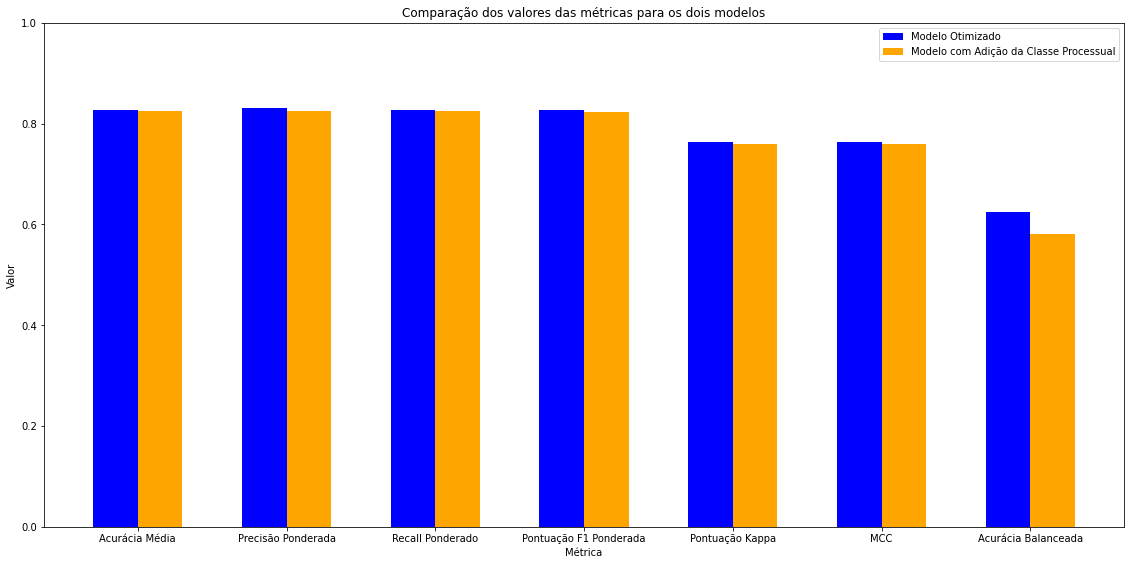

In [10]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_axes([0,0,1,1])
models = ['Modelo Otimizado', 'Modelo com Adição da Classe Processual']
x = ['Acurácia Média', 'Precisão Ponderada', 'Recall Ponderada', 'Pontuação F1 Ponderada', 'Acurácia Balanceada', 'Pontuação Kappa', 'MCC']
y1 = [frontback_metrics['Average Accuracy'], frontback_metrics['Weighted Precision'], frontback_metrics['Weighted Recall'], frontback_metrics['Weighted F1 Score'], frontback_metrics['Cohen Kappa Score'], frontback_metrics['Matthews Correlation Coefficient'], frontback_metrics['Balanced Accuracy']]
y2 = [proc_class_metrics['Average Accuracy'], proc_class_metrics['Weighted Precision'], proc_class_metrics['Weighted Recall'], proc_class_metrics['Weighted F1 Score'], proc_class_metrics['Cohen Kappa Score'], proc_class_metrics['Matthews Correlation Coefficient'], proc_class_metrics['Balanced Accuracy']]
X = np.arange(7)
ax.bar(X, y1, width=0.3, color='blue')
ax.bar(X + 0.3, y2, width=0.3, color='orange')
ax.set_title('Comparação dos valores das métricas para os dois modelos')
ax.set_ylim(top=1)
ax.set_xticks([.15, 1.15, 2.15, 3.15, 4.15, 5.15, 6.15])
ax.set_xticklabels(['Acurácia Média', 'Precisão Ponderada', 'Recall Ponderado', 'Pontuação F1 Ponderada', 'Pontuação Kappa', 'MCC', 'Acurácia Balanceada'])
ax.legend(models)
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.show()